In [1]:
# Import packages
# Make sure you have RiverREM imported, check readme for instructions
import os
import pathlib

import matplotlib.pyplot as plt
from load_plot_model import load_dtm, plot_model, plot_hist
from riverrem.REMMaker import REMMaker, clear_osm_cache
import requests
import rioxarray as rxr

In [2]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'watershed-project')

# Try/Except Block   
try:
    os.chdir(working_dir)
except:
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    os.chdir(working_dir)
else:
    print('{} is now the working directory'.format(working_dir))

/Users/lchipman/earth-analytics/data/watershed-project is now the working directory


# Load the UAV DTMs and REMs

In [3]:
# Define urls to UAV DTMs and REMs (saved on github)
# UAV DTM urls
highway93_dtm_url = ('https://github.com/lechipman/watershed-project/'
                  'releases/download/v1.0.0/hwy_93_DTM_2.tif')
applevalley_dtm_url = ('https://github.com/lechipman/watershed-project'
                        '/releases/download/v1.0.0/AV_DEM_2.tif')
hallmeadows_dtm_url = ('https://github.com/lechipman/watershed-project'
                        '/releases/download/v1.0.0/HM_DTM_2.tif')
# UAV REM urls
highway93_rem_url = ('https://github.com/lechipman/watershed-project/'
                     'releases/download/v1.0.0/'
                     'HM_REM_v1_RelativeDEM_Meter.tif')
applevalley_rem_url = ('https://github.com/lechipman/watershed-project/'
                       'releases/download/v1.0.0/'
                       'AV_REM_v4_RelativeDEM_Meter.tif')
hallmeadows_rem_url = ('https://github.com/lechipman/watershed-project/'
                       'releases/download/v1.0.0/'
                       'HM_REM_v1_RelativeDEM_Meter.tif')

In [4]:
# Load dataarrays for UAV-derived dtms and rems
highway93_uav_dtm = load_dtm(data_url = highway93_dtm_url, 
                          site_name = 'uav_h93',
                          file_name = 'dtm_highway93.tif')
applevalley_uav_dtm = load_dtm(data_url = applevalley_dtm_url, 
                          site_name = 'uav_av',
                          file_name = 'dtm_apple_valley.tif')
hallmeadows_uav_dtm = load_dtm(data_url = hallmeadows_dtm_url, 
                          site_name = 'uav_hm',
                          file_name = 'dtm_hall_meadows.tif')
highway93_uav_rem = load_dtm(data_url = highway93_rem_url, 
                          site_name = 'uav_h93',
                          file_name = 'dtm_highway93.tif')
applevalley_uav_rem = load_dtm(data_url = applevalley_rem_url, 
                          site_name = 'uav_av',
                          file_name = 'dtm_apple_valley.tif')
hallmeadows_uav_rem = load_dtm(data_url = hallmeadows_rem_url, 
                          site_name = 'uav_hm',
                          file_name = 'dtm_hall_meadows.tif')

# Lists of UAV DTMs and REMs
uav_dtm_list = [highway93_uav_dtm, 
                applevalley_uav_dtm, 
                hallmeadows_uav_dtm]

uav_rem_list = [highway93_uav_rem, 
                applevalley_uav_rem, 
                hallmeadows_uav_rem]

uav_h93 does not exist. Creating...
uav_h93/dtm_highway93.tif does not exist. Downloading...
uav_av does not exist. Creating...
uav_av/dtm_apple_valley.tif does not exist. Downloading...
uav_hm does not exist. Creating...
uav_hm/dtm_hall_meadows.tif does not exist. Downloading...


# Process LiDAR Data

In [5]:
# Set paths to LiDAR data (downloaded from CO hazard mapping
# Saved to local drive - look into downloading from url

# Directory for lidar data
lidar_dir = 'lidar_data'

# Paths to individual lidar files for each site
lidar_highway93_path = os.path.join(
    lidar_dir, 
    'lidar_highway93', 
    '3075_1760', 
    '3075_1760_elev.asc')

lidar_applevalley_path = os.path.join(
    lidar_dir, 
    'lidar_applevalley', 
    '3055_1875', 
    '3055_1875_elev.asc')

lidar_hallmeadows_path = os.path.join(
    lidar_dir, 
    'lidar_hallmeadows', 
    '3060_1865', 
    '3060_1865_elev.asc')

lidar_dtm_path_list = [lidar_highway93_path, 
                      lidar_applevalley_path, 
                      lidar_hallmeadows_path]

In [6]:
# Function to load lidar, reproject, clip, and save as .tif (for input inot riverrem)
def process_lidar(uav_dtm, lidar_path, name):
    
    """
    Loads the lidar DTM, reprojects, and clips to UAV DTM boundary. 
    Saves as a tif file for use in RiverREM
    
    Parameters
    ------------   
    dtm_name: dataarray
        The dtm to clip and reproject to.

    lidar_path: str
        Path to LiDAR.
        
    Returns
    -------
    lidar_dtm: dataarray.
        The processed lidar dtm.
    """
    
    # CRS of UAV DTM 
    uav_dtm_crs = uav_dtm.rio.crs
    
    # Find boundaries of uav_dtm
    xmin, ymin, xmax, ymax = (float(uav_dtm.x.min()), 
                          float(uav_dtm.y.min()), 
                          float(uav_dtm.x.max()), 
                          float(uav_dtm.y.max()))
    
    # Create dataarray for lidar DTM
    lidar_dtm = rxr.open_rasterio(lidar_path, masked=True)
    
    # Change CRS of lidar_dtm (2876) to uav_dtm_crs (4326)
    lidar_dtm_crs = lidar_dtm.rio.reproject(uav_dtm_crs)
    lidar_dtm_crs.rio.crs
    
    # Clip lidar dtm to UAV dtm
    lidar_clipped_dtm = (lidar_dtm_crs
                         .rio
                         .clip_box(xmin, ymin, xmax, ymax))
    
    # Save the clipped lidar dtm as raster for use in RiverREM
    # Work on saving to site directory
    lidar_clipped_dtm.rio.to_raster(("LiDAR_DTM_{}.tif").format(name))
    #lidar_clipped_dtm.rio.to_raster("LiDAR_DTM_highway93.tif")
    return lidar_clipped_dtm

In [7]:
# Run the process lidar function to create a lidar-derived DTM for each site
site_names = ('highway93', 'applevalley', 'hallmeadows')

# How to use .format with a non-string object?
#lidar_dtm_list = []
#for site in site_names:
 #   processed_lidar_dtm = process_lidar(uav_dtm = ({}_uav_dtm.format(site)),
  #                              lidar_path = lidar_{}_path.format(site),
   #                             name = site)
    #lidar_dtm_list.append(lidar_rem)
    

highway93_lidar_dtm = process_lidar(uav_dtm = highway93_uav_dtm,
                                lidar_path = lidar_highway93_path,
                                name = 'highway93')

applevalley_lidar_dtm = process_lidar(uav_dtm = applevalley_uav_dtm,
                                lidar_path = lidar_applevalley_path,
                                name = 'applevalley')

hallmeadows_lidar_dtm = process_lidar(uav_dtm = hallmeadows_uav_dtm,
                                lidar_path = lidar_hallmeadows_path,
                                name = 'hallmeadows')
lidar_dtm_list = [highway93_lidar_dtm, 
                  applevalley_lidar_dtm, 
                  hallmeadows_lidar_dtm]

# Plot UAV and LiDAR DTMs

In [8]:
# redo plot model function to loop through dtms/ax and plot each on new ax
# Move this to plot models.py
# Function to plot multiple elevation models
def plot_models(model, title, coarsen, ax):
    """
    Creates plots of multiple DTMs or REMs.
    
    Parameters
    ------------
    #row, col: int
     #   The number of rows and columns in figure.
        
    model: dataarray
        The dataarray to plot.

    title: str
        The title of the plot.
        
    coarsen: boolean
        True = coarsen data, False = do not coarsen.
    
    ax: axes
        A matplotlib axes object.

    Returns
    -------
    A plot of the elevation model with specified title.
    """

    # Hide x and y axes labels and ticks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # If DTM, coarsen
    if coarsen == True:
        model.coarsen(
            x=3,
            boundary='trim').mean().coarsen(
                y=3,
                boundary='trim').mean().squeeze()
    # Plot DTM
    model.plot(ax=ax)

    # Add title
    ax.set_title(title, fontsize=14)
    
    ax.legend('off')
    ax.axis('off')

In [ ]:
# Comparison plots of UAV and LiDAR DTMs
# Define plot space with x subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

# List of site names to pass to function for titles
plot_titles = ('Highway 93 UAV DTM', 
               'Apple Valley UAV DTM', 
               'Hall Meadows UAV DTM',
               'Highway 93 LiDAR DTM', 
               'Apple Valley LiDAR DTM', 
               'Hall Meadows LiDAR DTM')

# List of uav and lidar dtms to pass to plot function
all_dtm_list = [highway93_uav_dtm, 
                applevalley_uav_dtm, 
                hallmeadows_uav_dtm,
                highway93_lidar_dtm, 
                applevalley_lidar_dtm, 
                hallmeadows_lidar_dtm]

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=all_dtm_list[i],
        title=plot_titles[i],
        coarsen=(True, True, True, False, False, False),
        ax=axe)

# Just the LiDAR DTM Plots

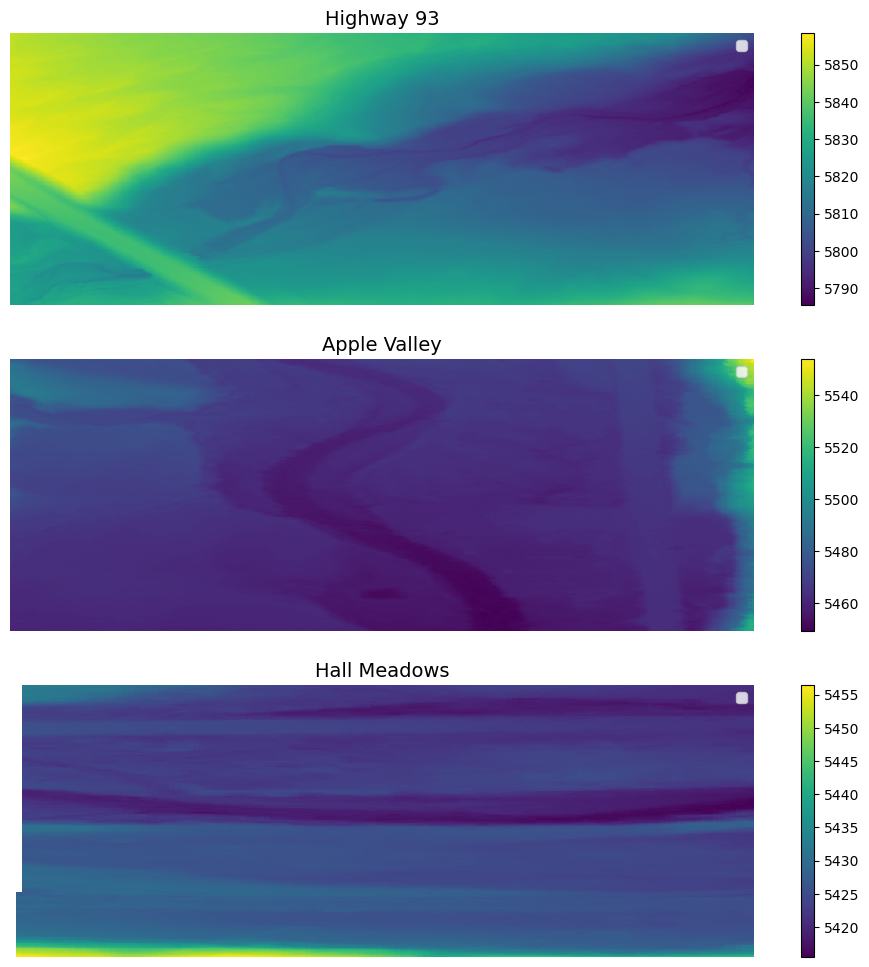

In [9]:
# Define plot space with x subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# List of site names to pass to function for title
plot_titles = ('Highway 93', 'Apple Valley', 'Hall Meadows')

# List of dtms to pass to function
lidar_dtm_list

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=lidar_dtm_list[i],
        title=plot_titles[i],
        coarsen=(False, False, False),
        ax=axe)

# Create LiDAR REMs Using REMMaker Tool

In [10]:
def run_rem_maker(name, k=100):
    """Run the REMMaker tool"""
    
    # Input the DTM file path and desired output directory
    override_cache = False
    lidar_dtm_path = os.path.join(('LiDAR_DTM_{}.tif').format(name))
    lidar_out_path = os.path.join(lidar_dir, ('lidar_{}').format(name))
    lidar_rem_path = os.path.join(lidar_out_path, 
                                  ('LiDAR_DTM_{}_REM.tif').format(name))

    # Run the REMMaker if the path to the REM does not already exist
    if (not os.path.exists(lidar_rem_path)) or override_cache:
        rem_maker = REMMaker(dem=lidar_dtm_path, 
                             out_dir=lidar_out_path, 
                             interp_pts=1000, 
                             k=100)

        # clear OSM cache
        clear_osm_cache()

        # create an REM
        rem_maker.make_rem()

        # create an REM visualization with the given colormap
        rem_maker.make_rem_viz(cmap='mako_r')

    else:
        print('The REM already exists. Not running REMMaker')

In [11]:
# Create REM for all sites with run_rem_maker function
site_names = ('highway93', 'applevalley', 'hallmeadows')
lidar_rem_list = []

for site in site_names:
    run_rem_maker(name=site)
    lidar_rem_path = os.path.join(lidar_dir,
                                  ('lidar_{}').format(site),
                                  ('LiDAR_DTM_{}_REM.tif').format(site))
    lidar_rem = rxr.open_rasterio(lidar_rem_path, masked=True)    
    lidar_rem_list.append(lidar_rem)

The REM already exists. Not running REMMaker
The REM already exists. Not running REMMaker
The REM already exists. Not running REMMaker


# Plot the UAV and LiDAR Derived REMs

In [ ]:
# Plot the REMs
# Define plot space with x subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

# List of site names to pass to function for titles
plot_title = ('UAV-Derived REM for Highway 93', 
              'UAV-Derived REM for Apple Valley', 
              'UAV-Derived REM for Hall Meadows',
              'LiDAR-Derived REM for Highway 93', 
              'LiDAR-Derived REM for Apple Valley', 
              'LiDAR-Derived REM for Hall Meadows')

# List of REMs to pass to plot function
all_rem_list = (uav_rem_list + lidar_rem_list)

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=all_rem_list[i],
        title=plot_title[i],
        coarsen=(True, True, True, False, False, False),
        ax=axe)
# Note - I increased value of k in the REMMAker and streaking improved!!
# "param k: number of nearest neighbors to use for IDW interpolation. If None, an appropriate value is estimated.
#  The estimation routine uses k between 5-100 points (0.5-10% of the river length) depending on the
#  sinuosity of the river of interest. Greater values of k are used for more sinuous rivers.""

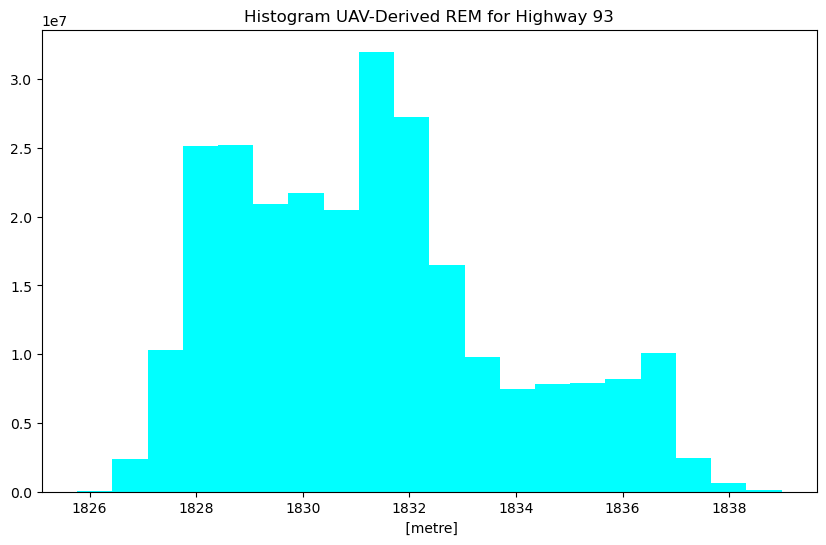

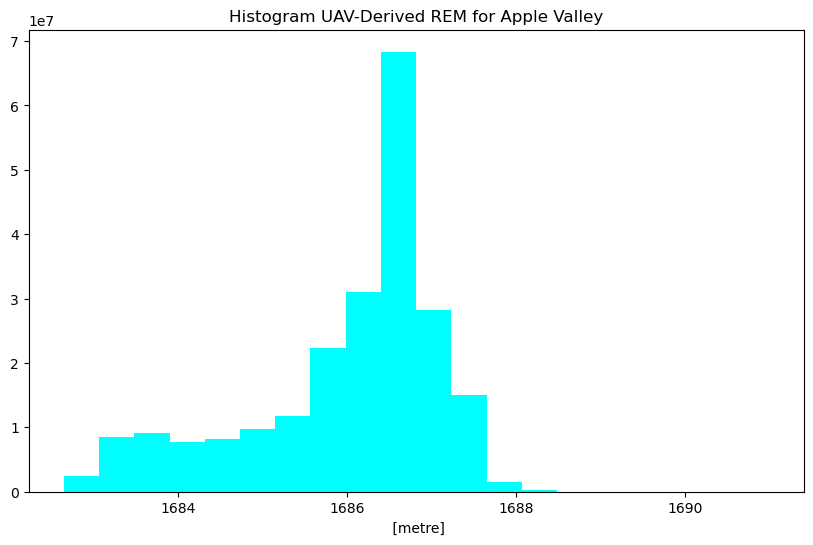

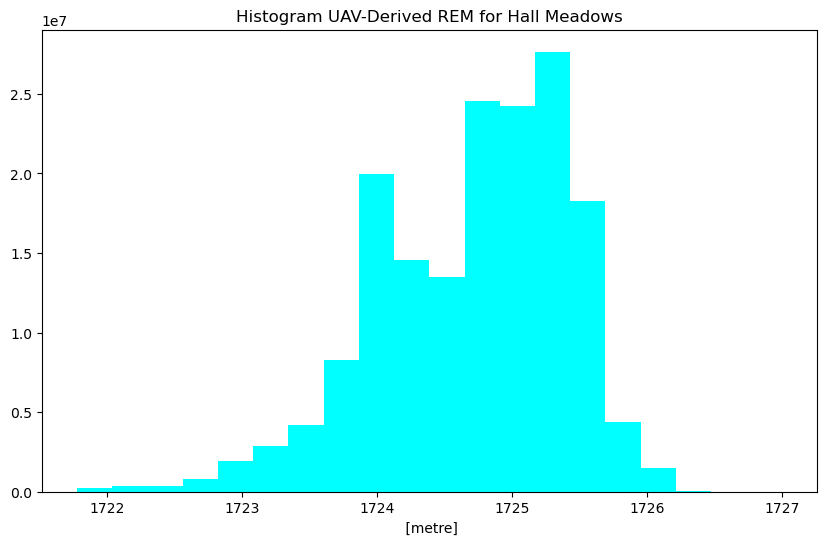

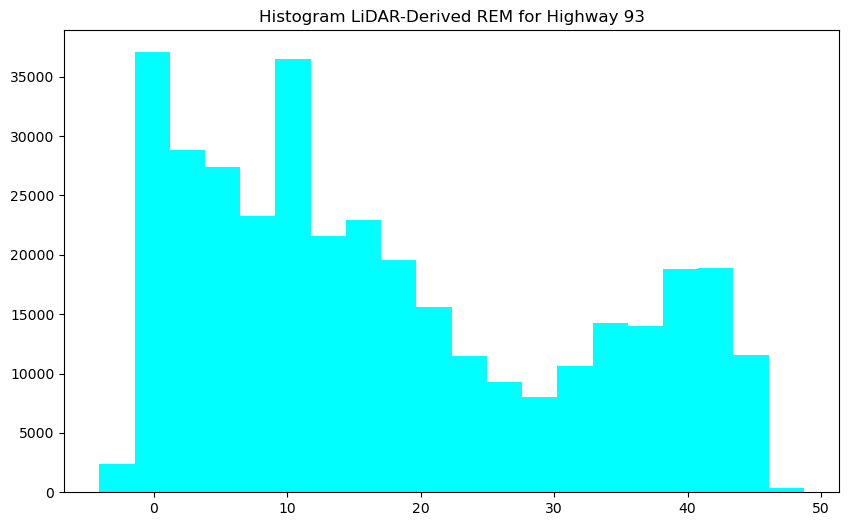

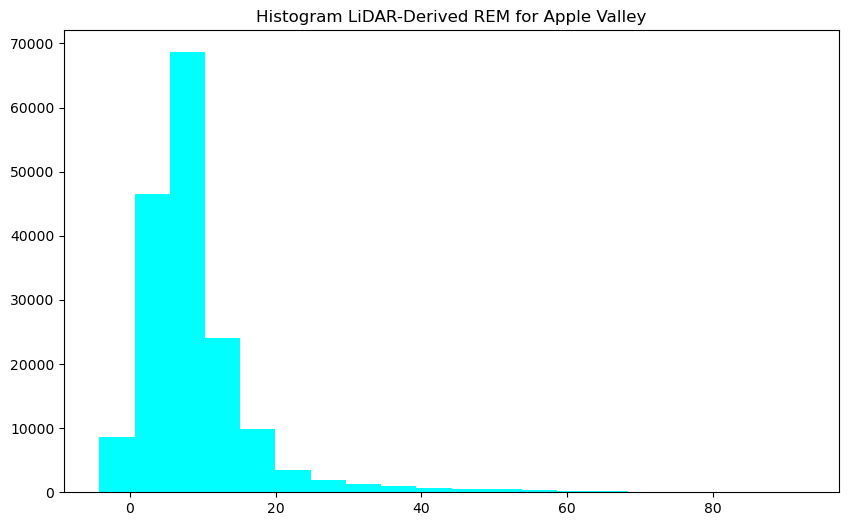

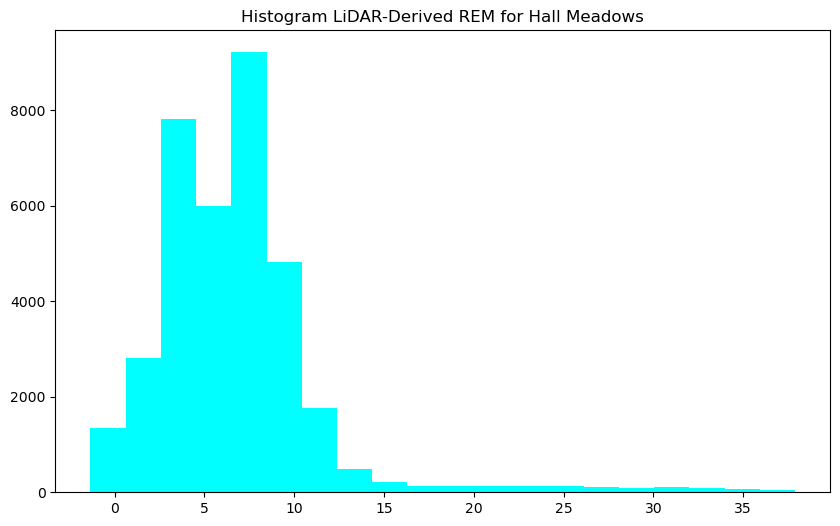

In [16]:
# Call function to plot histogram of REMs
# Plot the REMs
# Define plot space with x subplots
#fig, axes = plt.subplots(3, 1, figsize=(12, 14))

# List of site names to pass to function for titles
plot_title = ('Histogram UAV-Derived REM for Highway 93', 
              'Histogram UAV-Derived REM for Apple Valley', 
              'Histogram UAV-Derived REM for Hall Meadows',
              'Histogram LiDAR-Derived REM for Highway 93', 
              'Histogram LiDAR-Derived REM for Apple Valley', 
              'Histogram LiDAR-Derived REM for Hall Meadows')

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_hist(
        model=all_rem_list[i],
        title=plot_title[i],
        color='cyan')